In [1]:
import math
from simtk import unit
import os
import tempfile
import pickle
import mdtraj as md
import numpy as np
from simtk.unit.quantity import Quantity
import logging 
from tqdm import tqdm
# Set up logger
_logger = logging.getLogger()
_logger.setLevel(logging.INFO)

In [2]:
def get_trajs_for_state(i, aa, phase, length, out_dir, index, vanilla=False, htf=None):
    # From Hannah: https://github.com/hannahbrucemacdonald/endstate_pdbs/blob/master/scripts/input_for_pol_calc.py
    from perses.analysis.utils import open_netcdf
    nc = open_netcdf(os.path.join(out_dir, f"{i}_{phase}_{aa}_{length}.nc"))
    nc_checkpoint = open_netcdf(os.path.join(out_dir, f"{i}_{phase}_{aa}_{length}_checkpoint.nc"))
    checkpoint_interval = nc_checkpoint.CheckpointInterval
    all_positions = nc_checkpoint.variables['positions']
    n_iter, n_replicas, n_atoms, _ = np.shape(all_positions)
#     n_iter = 1001
    if not vanilla:
        new_top = md.Topology.from_openmm(htf._topology_proposal.new_topology)
        old_top = md.Topology.from_openmm(htf._topology_proposal.old_topology)

#         all_pos_new = np.zeros(shape=(n_iter, new_top.n_atoms, 3))
        all_pos_old = np.zeros(shape=(n_iter, old_top.n_atoms, 3))
        for iteration in tqdm(range(n_iter)):
            replica_id = np.where(nc.variables['states'][iteration*checkpoint_interval] == index)[0]
            pos = all_positions[iteration,replica_id,:,:][0] *unit.nanometers
            all_pos_old[iteration] = htf.old_positions(pos).value_in_unit_system(unit.md_unit_system) # Get new positions only
#             all_pos_old[iteration] = htf.old_positions(pos).value_in_unit_system(unit.md_unit_system)
    
#         return all_pos_new, all_pos_old
        return all_pos_old
    else:
        # Get topology
        with open(os.path.join(out_dir, f"{i}_{aa}_vanilla_topology.pickle"), "rb") as f:
            topology = pickle.load(f)
        all_pos = np.zeros(shape=(n_iter, topology.getNumAtoms(), 3))
        
        for iteration in tqdm(range(n_iter)):
            replica_id = np.where(nc.variables['states'][iteration*checkpoint_interval] == index)[0]
            all_pos[iteration] = all_positions[iteration,replica_id,:,:][0] *unit.nanometers
    
        return all_pos, topology
    


In [16]:
out_dir = "/data/chodera/zhangi/perses_benchmark/neq/12/83/"
i = os.path.basename(os.path.dirname(out_dir))
phase = 'complex'
endstate = 0
aa = 'ARG'.lower()
length = '1ns'
index = 11
with open(os.path.join(out_dir, f"{i}_{phase}_{endstate}.pickle"), "rb") as f:
    htf = pickle.load(f)


In [17]:
# new, old = get_trajs_for_state(i, aa, phase, length, out_dir, index, vanilla=True)
# pos_new, pos_old = get_trajs_for_state(i, aa, phase, length, out_dir, index, vanilla=False, htf=htf)
pos_old = get_trajs_for_state(i, aa, phase, length, out_dir, index, vanilla=False, htf=htf)

100%|██████████| 1001/1001 [29:28<00:00,  1.77s/it]


In [18]:
# traj_new = md.Trajectory(pos_new, md.Topology.from_openmm(htf._topology_proposal.new_topology))
# traj_new.save(out_dir + f"new_{index}.dcd")
# traj_new[0].save(out_dir + f"new_{index}.pdb")

In [19]:
box_vectors = np.array([val.value_in_unit_system(unit.md_unit_system) for val in htf.hybrid_system.getDefaultPeriodicBoxVectors()])

In [20]:
htf._topology_proposal.old_topology.setPeriodicBoxVectors(box_vectors)

In [21]:
htf._topology_proposal.old_topology.getPeriodicBoxVectors()

Quantity(value=array([[6.7997, 0.    , 0.    ],
       [0.    , 6.7997, 0.    ],
       [0.    , 0.    , 6.7997]]), unit=nanometer)

In [22]:
# Write PDB file using openmm bc it will include box vectors
from simtk.openmm import app
app.PDBFile.writeFile(htf._topology_proposal.old_topology, pos_old[0], open(os.path.join(out_dir, "test.pdb"), 'w'))

In [23]:
# Load pdb into mdtraj
pdb = md.load(os.path.join(out_dir, "test.pdb"))

In [24]:
pdb.unitcell_vectors

array([[[6.7997, 0.    , 0.    ],
        [0.    , 6.7997, 0.    ],
        [0.    , 0.    , 6.7997]]], dtype=float32)

In [25]:
traj_old = md.Trajectory(pos_old, md.Topology.from_openmm(htf._topology_proposal.old_topology))
# traj_old.unitcell_vectors = np.repeat(pdb.unitcell_vectors, 1001, axis=0)
# traj_old = traj_old.image_molecules()
# traj_old.save(out_dir + f"old_{index}.dcd") # index here indicates the index of the state
# traj_old[0].save(out_dir + f"old_{index}.pdb")

In [26]:
dihedrals_old = md.compute_dihedrals(traj_old, np.array([[1212, 1213, 1216, 1217]]))

In [27]:
import matplotlib.pyplot as plt

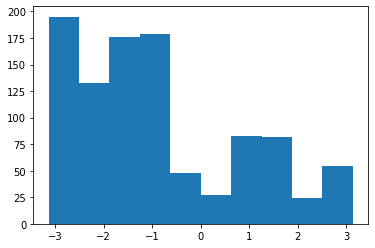

In [28]:
plt.hist(dihedrals_old)
plt.show()

In [13]:
htf._atom_classes['unique_old_atoms']

{694,
 695,
 696,
 697,
 698,
 699,
 700,
 701,
 702,
 703,
 706,
 707,
 708,
 709,
 710,
 711,
 712,
 713}

In [14]:
htf._atom_classes['unique_new_atoms']

{14877,
 14878,
 14879,
 14880,
 14881,
 14882,
 14883,
 14884,
 14885,
 14886,
 14887,
 14888,
 14889,
 14890}

In [ ]:
# Get traj for 8/31 neq old positions

In [10]:
with open("31_complex.pickle", "rb") as f:
    htf = pickle.load(f)


In [28]:
with open("31_complex_9_forward_neq_old.npy", "rb") as f:
    forward_neq_old = np.load(f)

In [29]:
with open("31_complex_9_reverse_neq_old.npy", "rb") as f:
    reverse_neq_old = np.load(f)

In [30]:
from simtk.openmm.app import Modeller
modeller = Modeller(htf._topology_proposal.old_topology, htf.old_positions(htf.hybrid_positions))
modeller.deleteWater()

In [31]:
traj_old = md.Trajectory(forward_neq_old, md.Topology.from_openmm(modeller.topology))
traj_old.save("31_complex_9_forward_neq_old.dcd") # index here indicates the index of the state

In [32]:
traj_old[0].save("31_complex_9_forward_neq_old.pdb")

In [33]:
traj_old = md.Trajectory(reverse_neq_old, md.Topology.from_openmm(modeller.topology))
traj_old.save("31_complex_9_reverse_neq_old.dcd") # index here indicates the index of the state

In [34]:
traj_old[0].save("31_complex_9_reverse_neq_old.pdb")

In [2]:
with open("/data/chodera/zhangi/perses_benchmark/neq/12/43/43_complex_trp_1ns_snapshots.npy", "rb") as f:
    pos = np.load(f)

In [3]:
with open("/data/chodera/zhangi/perses_benchmark/neq/12/43/43_complex_1.pickle", "rb") as f:
    htf = pickle.load(f)

In [33]:
pos_new = np.zeros(shape=(pos.shape[0], htf._topology_proposal.new_topology.getNumAtoms(), pos.shape[2]))
for i, p in enumerate(pos):
    pos_new[i] = htf.new_positions(p*unit.nanometers)

In [36]:
traj = md.Trajectory(pos_new, md.Topology.from_openmm(htf._topology_proposal.new_topology))

In [ ]:
traj.save("/data/chodera/zhangi/perses_benchmark/neq/12/43/43_complex_trp_1ns_snapshots.dcd")
traj[0].save("/data/chodera/zhangi/perses_benchmark/neq/12/43/43_complex_trp_1ns_snapshots.pdb")

In [2]:
with open("/data/chodera/zhangi/perses_benchmark/neq/12/42/42_complex_trp_1ns_snapshots.npy", "rb") as f:
    pos = np.load(f)

In [3]:
with open("/data/chodera/zhangi/perses_benchmark/neq/12/42/42_complex_0.pickle", "rb") as f:
    htf = pickle.load(f)

In [5]:
pos_old = np.zeros(shape=(pos.shape[0], htf._topology_proposal.old_topology.getNumAtoms(), pos.shape[2]))
for i, p in enumerate(pos):
    pos_old[i] = htf.old_positions(p*unit.nanometers)

In [6]:
traj = md.Trajectory(pos_old, md.Topology.from_openmm(htf._topology_proposal.old_topology))

In [7]:
traj.save("/data/chodera/zhangi/perses_benchmark/neq/12/42/42_complex_trp_1ns_snapshots.dcd")
traj[0].save("/data/chodera/zhangi/perses_benchmark/neq/12/42/42_complex_trp_1ns_snapshots.pdb")